In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import re

In [2]:
# Data clean up at file level

def clean_file(filein, fileout):
    with open(filein) as f:
        lines = f.readlines()

    cleanlines = []
    for line in lines:
        line = line.replace('\t', '#####')
        line = line.encode("ascii", "ignore").decode() # Remove ascii characters
        line = re.sub(r'\s+', ' ', line) # Remove mutliple white spaces
        line = line.lower() # All lowercase
        cleanlines.append(line)

    with open(fileout, 'w') as f:
        for linex in cleanlines:
            f.write("%s\n" % linex)


In [3]:
clean_file('./sentiment labelled sentences/imdb_labelled.txt', \
           './sentiment labelled sentences/imdb_labelled_clean.txt')
clean_file('./sentiment labelled sentences/yelp_labelled.txt', \
           './sentiment labelled sentences/yelp_labelled_clean.txt')
clean_file('./sentiment labelled sentences/amazon_cells_labelled.txt', 
           './sentiment labelled sentences/amazon_cells_labelled_clean.txt')


In [4]:
df_yelp = pd.read_csv('./sentiment labelled sentences/yelp_labelled_clean.txt', \
                      names=['sentence', 'score'], sep = '#####', engine = 'python')

df_amazon = pd.read_csv('./sentiment labelled sentences/amazon_cells_labelled_clean.txt', \
                        names=['sentence', 'score'], sep = '#####', engine = 'python')

df_imdb = pd.read_csv('./sentiment labelled sentences/imdb_labelled_clean.txt', \
                      names=['sentence', 'score'], sep = '#####', engine = 'python')


In [5]:
df_imdb.describe()

,score
count,1000.00000
mean,0.50000
std,0.50025
min,0.00000
25%,0.00000
50%,0.50000
75%,1.00000
max,1.00000


In [6]:
df_amazon.describe()

,score
count,1000.00000
mean,0.50000
std,0.50025
min,0.00000
25%,0.00000
50%,0.50000
75%,1.00000
max,1.00000


In [7]:
df_yelp.describe()

,score
count,1000.00000
mean,0.50000
std,0.50025
min,0.00000
25%,0.00000
50%,0.50000
75%,1.00000
max,1.00000


In [8]:
df_yelp.head()

,sentence,score
0,wow... loved this place.,1
1,crust is not good.,0
2,not tasty and the texture was just nasty.,0
3,stopped by during the late may bank holiday of...,1
4,the selection on the menu was great and so wer...,1


In [9]:

df_imdb.head()

,sentence,score
0,"a very, very, very slow-moving, aimless movie ...",0
1,not sure who was more lost - the flat characte...,0
2,attempting artiness with black & white and cle...,0
3,very little music or anything to speak of.,0
4,the best scene in the movie was when gerardo i...,1


In [10]:
df_amazon.head()

,sentence,score
0,so there is no way for me to plug it in here i...,0
1,"good case, excellent value.",1
2,great for the jawbone.,1
3,tied to charger for conversations lasting more...,0
4,the mic is great.,1


In [11]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split

def process_train_test_text(text, score, test_size):
    X_train, X_test, y_train, y_test = train_test_split(text, score, test_size=test_size, random_state=10)
    maxlen = text.apply(lambda x : len(re.findall(r'\w+', x))).max()
    tknzr = Tokenizer(oov_token = '<UNK>')
    tknzr.fit_on_texts(X_train)
    vocab_size = len(tknzr.word_index)+1
    word_index = tknzr.word_index
    train_sequences = tknzr.texts_to_sequences(X_train)
    test_sequences = tknzr.texts_to_sequences(X_test)
    train_padded = pad_sequences(train_sequences, padding='post', maxlen=maxlen)
    test_padded = pad_sequences(test_sequences, padding='post', maxlen=maxlen)
    return vocab_size, maxlen, word_index, train_sequences, test_sequences, train_padded, test_padded, y_train, y_test


def chart(fit_details, metric):
    plt.plot(fit_details.history[metric])
    plt.plot(fit_details.history['val_'+metric], '')
    plt.xlabel("Epochs")
    plt.ylabel(metric)
    plt.legend([metric, 'val_'+metric])
    plt.show()

    
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Embedding
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import GlobalAveragePooling1D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.callbacks import EarlyStopping

def sentiment_analysis(train_padded, test_padded, y_train, y_test, vocab_size):
    callback = EarlyStopping(monitor='val_loss', patience=3)
    model = Sequential()
    model.add(Embedding(input_dim=vocab_size, output_dim=10, mask_zero=True))
    model.add(GlobalAveragePooling1D())
    model.add(Dense(25, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(10, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    print(model.summary())

    fit_details = model.fit(train_padded, y_train.values, epochs=50, validation_split=0.2, callbacks=[callback])
    plt.figure(figsize=(16, 8))
    plt.subplot(1, 2, 1)
    chart(fit_details, 'accuracy')
    plt.figure(figsize=(16, 8))
    plt.subplot(1, 2, 2)
    chart(fit_details, 'loss')
    
    loss, accuracy = model.evaluate(test_padded, y_test.values)
    print('Accuracy: %f' % (accuracy*100))
    return model
    

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 10)          18140     
                                                                 
 global_average_pooling1d (G  (None, 10)               0         
 lobalAveragePooling1D)                                          
                                                                 
 dense (Dense)               (None, 25)                275       
                                                                 
 dropout (Dropout)           (None, 25)                0         
                                                                 
 dense_1 (Dense)             (None, 10)                260       
                                                                 
 dense_2 (Dense)             (None, 1)                 11        
                                                        

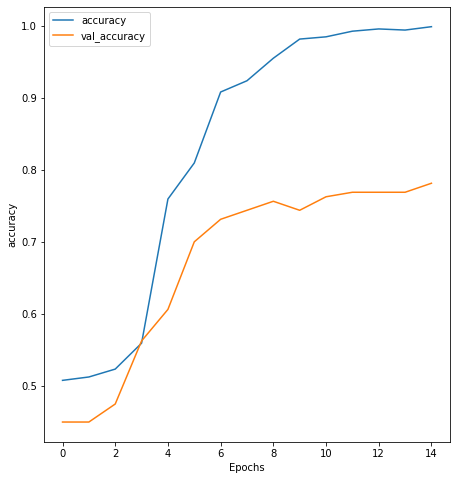

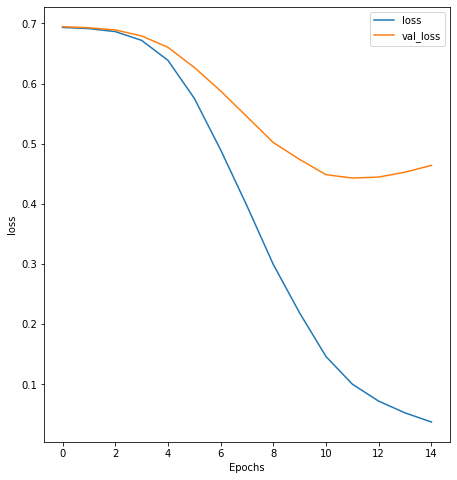

7/7 [==============================] - 0s 2ms/step - loss: 0.5562 - accuracy: 0.7950
Accuracy: 79.500002


In [12]:
vocab_size, maxlen, word_index, train_sequences, test_sequences, train_padded, test_padded, y_train, y_test = \
process_train_test_text(df_yelp['sentence'], df_yelp['score'], 0.2)
model = sentiment_analysis(train_padded, test_padded, y_train, y_test, vocab_size)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, None, 10)          16440     
                                                                 
 global_average_pooling1d_1   (None, 10)               0         
 (GlobalAveragePooling1D)                                        
                                                                 
 dense_3 (Dense)             (None, 25)                275       
                                                                 
 dropout_1 (Dropout)         (None, 25)                0         
                                                                 
 dense_4 (Dense)             (None, 10)                260       
                                                                 
 dense_5 (Dense)             (None, 1)                 11        
                                                      

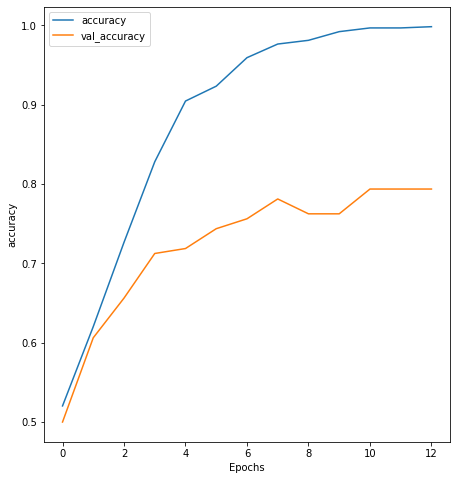

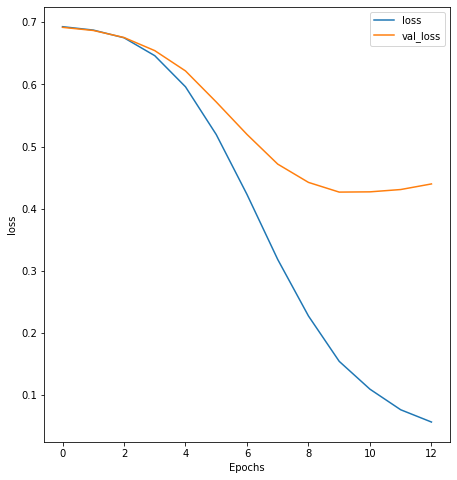

7/7 [==============================] - 0s 2ms/step - loss: 0.4806 - accuracy: 0.7700
Accuracy: 76.999998


In [13]:
vocab_size, maxlen, word_index, train_sequences, test_sequences, train_padded, test_padded, y_train, y_test = \
process_train_test_text(df_amazon['sentence'], df_amazon['score'], 0.2)
model = sentiment_analysis(train_padded, test_padded, y_train, y_test, vocab_size)

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, None, 10)          27560     
                                                                 
 global_average_pooling1d_2   (None, 10)               0         
 (GlobalAveragePooling1D)                                        
                                                                 
 dense_6 (Dense)             (None, 25)                275       
                                                                 
 dropout_2 (Dropout)         (None, 25)                0         
                                                                 
 dense_7 (Dense)             (None, 10)                260       
                                                                 
 dense_8 (Dense)             (None, 1)                 11        
                                                      

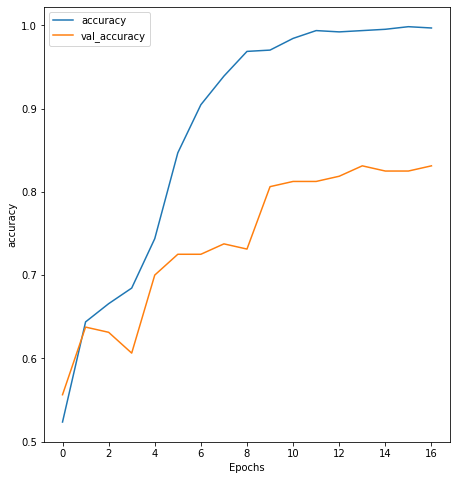

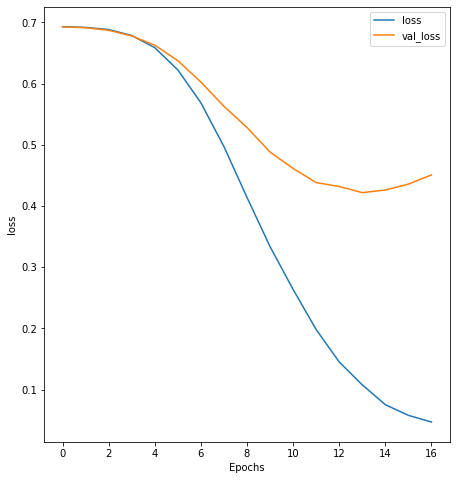

7/7 [==============================] - 0s 2ms/step - loss: 0.5489 - accuracy: 0.8000
Accuracy: 80.000001


In [14]:
vocab_size, maxlen, word_index, train_sequences, test_sequences, train_padded, test_padded, y_train, y_test = \
process_train_test_text(df_imdb['sentence'], df_imdb['score'], 0.2)
model = sentiment_analysis(train_padded, test_padded, y_train, y_test, vocab_size)

In [16]:
# Save model as JSON file and weights in .h5 file
json_model = model.to_json()
with open("./sentiment labelled sentences/tensorflow_sentiment_model.json", "w") as file:
    file.write(json_model)

model.save_weights("./sentiment labelled sentences/tensorflow_sentiment_model_weights.h5")
